# BERT Lab

In 2018, models such as [BERT](https://arxiv.org/abs/1810.04805), [Open GPT](https://openai.com/blog/better-language-models/) and [ELMO](https://arxiv.org/abs/1802.05365) were released and performed well on many benchmark NLP tasks with minimal task-specific tuning. The publicly available pretrained models can be used either to extract high quality language features from your text data, or fine-tuned on a specific task (classification, entity recognition, etc.) with your data to produce [state of the art predictions](https://gluebenchmark.com/leaderboard).

In this notebook we will use a pre-trained BERT model to **extract features**, namely word embedding vectors, from text data. We will explore different ways of extracting these embeddings and build a simple binary classifier model to compare different embedding approaches.

Traditionally, words were converted to their vector representations by either **uniquely indexing (one-hot encoding)** them or using neural network based word embeddings such as **Word2Vec or Fasttext**. BERT offers an advantage over models like Word2Vec because while each word has a fixed representation in Word2Vec regardless of the context within which the word appears, BERT produces word representations that are dynamically informed by the words around them. For example, given two sentences:

<font color='green'>The man was accused of robbing a bank.</font>

<font color='green'>The man went fishing by the bank of the river.</font>

Models such as Word2Vec would produce the same word embeddings for the word _"bank"_ in both sentences (embeddings remain the same regardless of the context), while in BERT word embeddings for _"bank"_ would be different for  both sentences. 

*Note that this is in no way a detailed or a comprehensive explanation on BERT architecture (or its alternatives). It is a brief introduction to BERT and we explore how pre-trained BERT models can be used to extract word embeddings. We will use these embeddings for a simple classification task where we try to predict if a piece of text is a positive or a negative review.*

#### This notebook has two sections:
I. **BERT Embeddings Walk Through**:
    Here we explore how to extract embeddings from a pre-trained BERT model.

II. **Classification**:
    Here we build a base binary classification model (logisitic regression) for a binary classification task. Your task will be to try improving the model performance.


## I. BERT Embeddings Walk Through

### Format the input sentence

BERT expects input sentences to be in a specific format:

- Tokens to mark the beginning ([CLS]) and separation/end of sentences ([SEP])
- Word piece tokenization
- Segment IDs used to distinguish different sentences

![bert-input-format](https://i.imgur.com/Z8MXvQG.png)

In [1]:
# Install the required modules
!pip install transformers
!pip install pandas
!pip install numpy
!pip install tqdm
!pip install sklearn

  Using cached https://files.pythonhosted.org/packages/28/5c/cf6a2b65a321c4a209efcdf64c2689efae2cb62661f8f6f4bb28547cf1bf/joblib-0.14.1-py2.py3-none-any.whl
  Stored in directory: C:\Users\ADMIN\AppData\Local\pip\Cache\wheels\6d\ec\1a\21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses
  Stored in directory: C:\Users\ADMIN\AppData\Local\pip\Cache\wheels\76\03\bb\589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [2]:
# We are loading a smaller 'bert-base-uncased' model for this notebook. For more information on pre-trained models, check this: https://github.com/google-research/bert#pre-trained-models
import torch
from transformers import *

# model -> BertModel
# tokenizer -> BertTokenizer
# model name -> 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

I0216 12:04:36.284759 15268 file_utils.py:38] PyTorch version 1.4.0 available.
I0216 12:04:41.748416 15268 filelock.py:274] Lock 3154149138504 acquired on C:\Users\ADMIN\.cache\torch\transformers\26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084.lock
I0216 12:04:41.749415 15268 file_utils.py:413] https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt not found in cache or force_download set to True, downloading to C:\Users\ADMIN\.cache\torch\transformers\tmpc7lw4759


I0216 12:04:42.427872 15268 file_utils.py:423] storing https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt in cache at C:\Users\ADMIN\.cache\torch\transformers\26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
I0216 12:04:42.429872 15268 file_utils.py:426] creating metadata file for C:\Users\ADMIN\.cache\torch\transformers\26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
I0216 12:04:42.430871 15268 filelock.py:318] Lock 3154149138504 released on C:\Users\ADMIN\.cache\torch\transformers\26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084.lock
I0216 12:04:42.431872 15268 tokenization_utils.py:418] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at C:\Users\ADMIN\.cache\t

#### Tokenization

In the example below, the word "ephemeral" is split into smaller subwords and characters. Hash signs preceding these subwords are the tokenizer's way of denoting that this subword or character is part of a larger word and preceded by another subword. 

The BERT tokenizer was created with a WordPiece model. This model greedily creates a fixed-size vocabulary of individual characters, subwords, and words that best fit our language data. To tokenize a word in this model, the tokenizer first checks if the whole word is in the vocabulary. If not, it tries to break the word into the largest possible subwords contained in the vocabulary, and as a last resort will decompose the word into individual characters. Note that because of this, we don't run into the problem of out of vocabulary words.

So, rather than assigning "ephemeral" and every other out of vocabulary word to something like 'UNK' (unknown vocabulary token), we split it into subword tokens ['ep', '##hem', '##eral'] that will retain some of the contextual meaning of the original word.


(For more information about WordPiece, see the [original paper](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/37842.pdf) and further disucssion in Google's [Neural Machine Translation System](https://arxiv.org/pdf/1609.08144.pdf).)



In [3]:
# Using the BERT tokenizer
example_text = "ephemeral"
print(tokenizer.tokenize(example_text))

['ep', '##hem', '##eral']


In [4]:
example_text2 = "amatorculist"
print(tokenizer.tokenize(example_text2))

['ama', '##tor', '##cu', '##list']


In [5]:
# Adding tokens [CLS] and [SEP] at start and end of a sentence
text = "After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank."
marked_text = "[CLS] " + text + " [SEP]"

print (marked_text)

# Using BERT word piece tokenizer 
tokenized_text = tokenizer.tokenize(marked_text)
print ("\nAfter tokenization:\n",tokenized_text)

[CLS] After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank. [SEP]

After tokenization:
 ['[CLS]', 'after', 'stealing', 'money', 'from', 'the', 'bank', 'vault', ',', 'the', 'bank', 'robber', 'was', 'seen', 'fishing', 'on', 'the', 'mississippi', 'river', 'bank', '.', '[SEP]']


#### Segment IDs

BERT is trained on and expects sentence pairs (The [SEP] token is used to separate multiple sentences), using 1s and 0s to distinguish between the two sentences. 

That is, for each token in "tokenized_text," we must specify which sentence it belongs to: sentence 0 (a series of 0s) or sentence 1 (a series of 1s). For our purposes, single-sentence inputs only require a series of 1s, so we will create a vector of 1s for each token in our input sentence. 

If you want to process two sentences, assign each word in the first sentence plus the '[SEP]' token a 0, and all tokens of the second sentence a 1.

Essentially you can have multiple sentence pairs as shown below:

- **"<font color='green'>[CLS] The man was accused of robbing a bank. [SEP] The man was seen fishing by the river bank. [SEP]</font>"**
  - tokens in this case would be: ['[CLS]', 'the', 'man', 'was', 'accused', 'of', 'robb', '##ing', 'a', 'bank', '.', '[SEP]', 'the', 'man', 'was', 'seen', 'fishing', 'by', 'the', 'river', 'bank', '.', '[SEP]']
  - segment ids in this case would be: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  

or you can have it as two separate sentences as shown below:

- **"<font color='green'>[CLS] The man was accused of robbing a bank. [SEP]</font>"**
  - tokens in this case would be: ['[CLS]', 'the', 'man', 'was', 'accused', 'of', 'robb', '##ing', 'a', 'bank', '.', '[SEP]']
  - segment ids in this case would be: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

- **"<font color='green'>[CLS] The man was seen fishing by the river bank. [SEP]</font>"**
  - tokens in this case would be: ['[CLS]', 'the', 'man', 'was', 'seen', 'fishing', 'by', 'the', 'river', 'bank', '.', '[SEP]']
  - segment ids in this case would be: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [6]:
# For our task we're using single sentence per input text
segments_ids = [0] * len(tokenized_text)
print (segments_ids)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


#### Convert tokens to indices

We call the tokenizer to match the tokens against their indices in the tokenizer vocabulary

In [7]:
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

for tup in zip(tokenized_text, indexed_tokens):
    print(tup)

('[CLS]', 101)
('after', 2044)
('stealing', 11065)
('money', 2769)
('from', 2013)
('the', 1996)
('bank', 2924)
('vault', 11632)
(',', 1010)
('the', 1996)
('bank', 2924)
('robber', 27307)
('was', 2001)
('seen', 2464)
('fishing', 5645)
('on', 2006)
('the', 1996)
('mississippi', 5900)
('river', 2314)
('bank', 2924)
('.', 1012)
('[SEP]', 102)


### Forward pass the input sentence

1. The pre-trained BERT PyTorch interface expects the data be in torch tensor format so we first convert the segment_ids and tokenized text 
 
2. model.eval() puts our model in evaluation mode as opposed to training mode.

3. Calling `from_pretrained` will download the pre-trained model specified. When we load the `bert-base-uncased`, we see the definition of the model printed. This particular model has 13 layers (the forward pass of the model includes the outputs of the initial embedding in addition to the encoder states, so we get 13 layers).

In [8]:
import torch

# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states=True)

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

I0216 14:16:23.467798 15268 filelock.py:274] Lock 3154290066824 acquired on C:\Users\ADMIN\.cache\torch\transformers\4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.8f56353af4a709bf5ff0fbc915d8f5b42bfff892cbb6ac98c3c45f481a03c685.lock
I0216 14:16:23.468799 15268 file_utils.py:413] https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json not found in cache or force_download set to True, downloading to C:\Users\ADMIN\.cache\torch\transformers\tmp5ehrrsle


I0216 14:16:23.909138 15268 file_utils.py:423] storing https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json in cache at C:\Users\ADMIN\.cache\torch\transformers\4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.8f56353af4a709bf5ff0fbc915d8f5b42bfff892cbb6ac98c3c45f481a03c685
I0216 14:16:23.911138 15268 file_utils.py:426] creating metadata file for C:\Users\ADMIN\.cache\torch\transformers\4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.8f56353af4a709bf5ff0fbc915d8f5b42bfff892cbb6ac98c3c45f481a03c685
I0216 14:16:23.912137 15268 filelock.py:318] Lock 3154290066824 released on C:\Users\ADMIN\.cache\torch\transformers\4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.8f56353af4a709bf5ff0fbc915d8f5b42bfff892cbb6ac98c3c45f481a03c685.lock
I0216 14:16:23.916139 15268 configuration_utils.py:254] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at C:\U

I0216 14:17:11.001804 15268 file_utils.py:423] storing https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-pytorch_model.bin in cache at C:\Users\ADMIN\.cache\torch\transformers\aa1ef1aede4482d0dbcd4d52baad8ae300e60902e88fcb0bebdec09afd232066.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157
I0216 14:17:11.002805 15268 file_utils.py:426] creating metadata file for C:\Users\ADMIN\.cache\torch\transformers\aa1ef1aede4482d0dbcd4d52baad8ae300e60902e88fcb0bebdec09afd232066.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157
I0216 14:17:11.004803 15268 filelock.py:318] Lock 3154297359216 released on C:\Users\ADMIN\.cache\torch\transformers\aa1ef1aede4482d0dbcd4d52baad8ae300e60902e88fcb0bebdec09afd232066.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157.lock
I0216 14:17:11.005806 15268 modeling_utils.py:458] loading weights file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-pytorch_model.bin from cache at C:\

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [9]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

# Predict hidden states features for each layer
with torch.no_grad():
    encoded_layers = model(tokens_tensor, token_type_ids=segments_tensors)

In [10]:
# layers x batch_size x sequence length x hidden state dimension
n_layers, batch_size, sequence_length, hidden_state_dim = encoded_layers[-1], encoded_layers[0], encoded_layers[0][0], encoded_layers[0][0][0]
len(n_layers), len(batch_size), len(sequence_length), len(hidden_state_dim)

(13, 1, 22, 768)

In [16]:
len(encoded_layers)

3

In [22]:
print(encoded_layers[0].shape)
print(encoded_layers[1].shape)
print(type(encoded_layers[2]))

torch.Size([1, 22, 768])
torch.Size([1, 768])
<class 'tuple'>


In [23]:
len(encoded_layers[2])

13

In [15]:
# print(type(encoded_layers)) 
# <class 'tuple'>
print(encoded_layers)

(tensor([[[-0.4964, -0.1831, -0.5231,  ..., -0.1902,  0.3738,  0.3964],
         [-0.1323, -0.2762, -0.3495,  ..., -0.4567,  0.3786, -0.1096],
         [-0.3626, -0.4002,  0.0676,  ..., -0.3207, -0.2709, -0.3004],
         ...,
         [ 0.2961, -0.2856, -0.0382,  ..., -0.6056, -0.5163,  0.2005],
         [ 0.4878, -0.0909, -0.2358,  ..., -0.0017, -0.5945, -0.2431],
         [-0.2517, -0.3519, -0.4688,  ...,  0.2500,  0.0336, -0.2627]]]), tensor([[-0.6031, -0.3342, -0.7174,  0.3347,  0.5145, -0.1722,  0.4502,  0.2768,
         -0.3769, -0.9998, -0.3657,  0.7535,  0.9817, -0.0192,  0.7959, -0.3459,
         -0.1338, -0.3026,  0.1097,  0.5836,  0.5736,  0.9999,  0.1798,  0.1845,
          0.2250,  0.9109, -0.5653,  0.8616,  0.8994,  0.7423, -0.2525,  0.0394,
         -0.9894, -0.1331, -0.7763, -0.9826,  0.2223, -0.6115,  0.1941,  0.0177,
         -0.7634,  0.2312,  0.9999, -0.7000,  0.4623, -0.2202, -1.0000,  0.1908,
         -0.8150,  0.6483,  0.5878,  0.8198,  0.1014,  0.3185,  0.3963

         [-0.2517, -0.3519, -0.4688,  ...,  0.2500,  0.0336, -0.2627]]])))


#### BERT output

The `encoded_layers` variable in the section above has four dimensions:

1. The layer number (13 layers)
2. The batch number (1 sentence)
3. The word / token number (number of tokens in our sentence)
4. Hidden state for that layer (768 features)

In [24]:
# Convert the hidden state embeddings into single token vectors

# Will have the shape: [# tokens, # layers, # features]
token_embeddings = [] 

batch_i = 0
# For each token in the sentence...
for token_i in range(len(tokenized_text)):
  
    # Holds 12 layers of hidden states for each token 
    hidden_layers = [] 

    # For each of the 12 layers...[last layer is excluded. See issue : https://github.com/huggingface/transformers/issues/1332]
    for layer_i in range(len(encoded_layers[-1][0:12])):

        # Lookup the vector for `token_i` in `layer_i`
        vec = encoded_layers[-1][layer_i][batch_i][token_i]

        hidden_layers.append(vec)
    
    token_embeddings.append(hidden_layers)

# Sanity check the dimensions:
print ("Number of tokens in sequence:", len(token_embeddings))
print ("Number of layers per token:", len(token_embeddings[0]))

Number of tokens in sequence: 22
Number of layers per token: 12


### Create word and sentence embeddings


To extract features we'd like individual vectors for each of our tokens, or even a single vector representation of the whole sentence.

In order to get the individual vectors we can combine some of the layer vectors. BERT authors tested different combinations of this by feeding different vector combinations as input features to a BiLSTM used on a named entity recognition task and observing the resulting F1 scores.

![bert-feature-extraction-contextualized-embeddings](https://jalammar.github.io/images/bert-feature-extraction-contextualized-embeddings.png)

Using the last four layers produced the best results on this specific task. Many of the other methods returned close results, and so it is advisable to test different versions depending on the specific application.

#### Word vectors

Let's create word vectors by **using just the last layer**, to give us a single vector per token. Each of those vectors will have a length of `768`. 

In [25]:
# Every token vector : [sentence sequence length x 768]
token_vecs = [each_token[-1] for each_token in token_embeddings]

print('shape of token_vecs: %d x %d' % (len(token_vecs), len(token_vecs[0])))

shape of token_vecs: 22 x 768


Another way of creating word vectors is by **summing** together the last four layers.

In [26]:
# Stores the token vectors, with shape [sentence sequence length x 768]
token_vecs_sum = []

# For each token in the sentence...
for token in token_embeddings:
    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(torch.stack(token)[-4:], 0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 22 x 768


#### Sentence vectors
To get a single vector for our entire sentence we have multiple application-dependent strategies, but a simple approach is to average the last hidden layer of each token, producing a single 768 length vector. 
<a href="https://stackoverflow.com/questions/29760935/how-to-get-vector-for-a-sentence-from-the-word2vec-of-tokens-in-sentence#answer-31738627">Here</a> are different ways of creating sentence vectors from word vectors (the link refers to Word2Vec embeddings, however the approach can be used here as well). 

In [27]:
sentence_embedding = torch.mean(encoded_layers[-1][11], 1)
print("shape of sentence embedding", list(sentence_embedding.shape))

shape of sentence embedding [1, 768]


### Confirming contextually dependent vectors

To confirm that the value of these vectors are in fact contextually dependent, let's take a look at the output from the following sentence:

In [28]:
print (text)

After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank.


In [29]:
for i,x in enumerate(tokenized_text):
    print(i,x)

0 [CLS]
1 after
2 stealing
3 money
4 from
5 the
6 bank
7 vault
8 ,
9 the
10 bank
11 robber
12 was
13 seen
14 fishing
15 on
16 the
17 mississippi
18 river
19 bank
20 .
21 [SEP]


In [30]:
from sklearn.metrics.pairwise import cosine_similarity

# Compare "bank" as in "bank robber" to "bank" as in "river bank"
different_bank = cosine_similarity(token_vecs_sum[10].reshape(1,-1), token_vecs_sum[19].reshape(1,-1))[0][0]

# Compare "bank" as in "bank robber" to "bank" as in "bank vault" 
same_bank = cosine_similarity(token_vecs_sum[10].reshape(1,-1), token_vecs_sum[6].reshape(1,-1))[0][0]

In [31]:
print ("Similarity of 'bank' as in 'bank robber' to 'bank' as in 'bank vault':",  same_bank)

Similarity of 'bank' as in 'bank robber' to 'bank' as in 'bank vault': 0.92893326


In [32]:
print ("Similarity of 'bank' as in 'bank robber' to 'bank' as in 'river bank':",  different_bank)

Similarity of 'bank' as in 'bank robber' to 'bank' as in 'river bank': 0.6819416


#### <font color='red'>Try for yourself</font>

Can you find one more example where the similarity of word embeddings for the same word in a similar context (such as 'bank' in 'bank robber' and 'bank' in 'bank vault') is greater than the similarity of word embeddings for same words in a different context (such as 'bank' in 'bank robber' and 'river bank').

## II. Classification

Next we'll use the `bert-base-uncased` pre-trained model and test the embeddings on a classification task. For this task we'll be using a food reviews dataset and build a small classification model to classify reviews as either positive or negative. 

For this exercise we take a look at two ways of creating word embeddings:
1. **Summing** together the hidden state of the last four layers. 
2. Using the hidden state of the last layer only.

Both of these methods would create a word embedding of shape 768. One simple way of creating **sentence embeddings** is to extract word vectors for each of the tokens in a given sentence and calculate the mean vector of all the token embeddings. This is how we'll be creating our sentence embeddings for this exercise.

### Data preparation

In [33]:
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
import numpy as np

In [34]:
def show_confusion_matrix(C, class_labels=['0', '1']):
    """
    :C: shape (2,2) as given by scikit-learn confusion_matrix function ['ndarray']
    :class_labels: list of strings, default simply labels 0 and 1 ['List']

    Draws confusion matrix with associated metrics.
    """
    import matplotlib.pyplot as plt

    assert C.shape == (2, 2), "Confusion matrix should be from binary classification only."

    # true negative, false positive, etc...
    tn = C[0, 0]
    fp = C[0, 1]
    fn = C[1, 0]
    tp = C[1, 1]

    NP = fn + tp  # Num positive examples
    NN = tn + fp  # Num negative examples
    N = NP + NN

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5, 2.5)
    ax.set_ylim(2.5, -0.5)
    ax.plot([-0.5, 2.5], [0.5, 0.5], '-k', lw=2)
    ax.plot([-0.5, 2.5], [1.5, 1.5], '-k', lw=2)
    ax.plot([0.5, 0.5], [-0.5, 2.5], '-k', lw=2)
    ax.plot([1.5, 1.5], [-0.5, 2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34, 1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''], rotation=90)
    ax.set_yticks([0, 1, 2])
    ax.yaxis.set_label_coords(-0.09, 0.65)

    # Fill in initial metrics: tp, tn, etc...
    ax.text(0, 0,
            'True Neg: %d\n(Num Neg: %d)' % (tn, NN),
            va='center',
            ha='center',
            bbox=dict(fc='w', boxstyle='round,pad=1'))

    ax.text(0, 1,
            'False Neg: %d' % fn,
            va='center',
            ha='center',
            bbox=dict(fc='w', boxstyle='round,pad=1'))

    ax.text(1, 0,
            'False Pos: %d' % fp,
            va='center',
            ha='center',
            bbox=dict(fc='w', boxstyle='round,pad=1'))

    ax.text(1, 1,
            'True Pos: %d\n(Num Pos: %d)' % (tp, NP),
            va='center',
            ha='center',
            bbox=dict(fc='w', boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2, 0,
            'False Pos Rate: %.2f' % (fp / (fp + tn + 0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w', boxstyle='round,pad=1'))

    ax.text(2, 1,
            'True Pos Rate: %.2f' % (tp / (tp + fn + 0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w', boxstyle='round,pad=1'))

    ax.text(2, 2,
            'Accuracy: %.2f' % ((tp + tn + 0.) / N),
            va='center',
            ha='center',
            bbox=dict(fc='w', boxstyle='round,pad=1'))

    ax.text(0, 2,
            'Neg Pre Val: %.2f' % (1 - fn / (fn + tn + 0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w', boxstyle='round,pad=1'))

    ax.text(1, 2,
            'Pos Pred Val: %.2f' % (tp / (tp + fp + 0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w', boxstyle='round,pad=1'))

    plt.tight_layout()
    plt.show()

In [35]:
class Embeddings:
    LAST_LAYER = 1
    LAST_4_LAYERS = 2
    def __init__(self):
        self._tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self._bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
        self._bert_model.eval()

    def tokenize(self, sentence):
        """

        :param sentence: input sentence ['str']
        :return: tokenized sentence based on word piece model ['List']
        """
        marked_sentence = "[CLS] " + sentence + " [SEP]"
        tokenized_text = self._tokenizer.tokenize(marked_sentence)
        return tokenized_text

    def get_bert_embeddings(self, sentence):
        """

        :param sentence: input sentence ['str']
        :return: BERT pre-trained hidden states (list of torch tensors) ['List']
        """
        # Predict hidden states features for each layer

        tokenized_text = self.tokenize(sentence)
        indexed_tokens = self._tokenizer.convert_tokens_to_ids(tokenized_text)

        segments_ids = [0] * len(tokenized_text)

        # Convert inputs to PyTorch tensors
        tokens_tensor = torch.tensor([indexed_tokens])
        segments_tensors = torch.tensor([segments_ids])

        with torch.no_grad():
            encoded_layers = self._bert_model(tokens_tensor, token_type_ids=segments_tensors)

        return encoded_layers[-1][0:12]

    def sentence2vec(self, sentence, layers):
        """

        :param sentence: input sentence ['str']
        :param layers: parameter to decide how word embeddings are obtained ['str]
            1. 'last' : last hidden state used to obtain word embeddings for sentence tokens
            2. 'last_4' : last 4 hidden states used to obtain word embeddings for sentence tokens

        :return: sentence vector [List]
        """
        encoded_layers = self.get_bert_embeddings(sentence)
        
        if layers == 1:
            # using the last layer embeddings
            token_embeddings = encoded_layers[-1]
            # summing the last layer vectors for each token
            sentence_embedding = torch.mean(token_embeddings, 1)
            return sentence_embedding.view(-1).tolist()

        elif layers == 2:
            token_embeddings = []
            tokenized_text = self.tokenize(sentence)

            batch_i = 0
            # For each token in the sentence...
            for token_i in range(len(tokenized_text)):

                # Holds 12 layers of hidden states for each token
                hidden_layers = []

                # For each of the 12 layers...
                for layer_i in range(len(encoded_layers)):
                    # Lookup the vector for `token_i` in `layer_i`
                    vec = encoded_layers[layer_i][batch_i][token_i]

                    hidden_layers.append(list(vec.numpy()))

                token_embeddings.append(hidden_layers)

            # using the last 4 layer embeddings
            token_vecs_sum = []

            # For each token in the sentence...
            for token in token_embeddings:
                # Sum the vectors from the last four layers.
                sum_vec = np.sum(token[-4:], axis=0)

                # Use `sum_vec` to represent `token`.
                token_vecs_sum.append(list(sum_vec))

            # summing the last layer vectors for each token
            sentence_embedding = np.mean(token_vecs_sum, axis=0)
            return sentence_embedding.ravel().tolist()


In [36]:
def model_grid_search(parameters, x_train, y_train, model, scoring):
    """

    :param parameters: hyperparameter choices to tune. Eg:
                    Hyperparameter values for logistic regression
                    {'loss' :['log'],
                    'penalty':['l1','l2','elasticnet'],
                    'alpha':[float(i)/10000000 for i in range(1,5,1)],
                    'n_jobs':[-1]}

                    [dict]

    :param x_train: training data (2D matrix) [List or ndarray]
    :param y_train: training data predictor values [List or ndarray]
    :param model: sklearn model to perform gridsearch on
    :param scoring: Finds the best model based on the scoring metric used (https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)
    :return: grid search instance with information on all trained classifiers
    """
    clf = GridSearchCV(model, parameters, cv=5, scoring=scoring)
    clf.fit(x_train, y_train)
    return clf


def test_metrics(y_pred, y_test):
    """
    
    :param y_pred: predicted values [List]
    :param y_test: actual predictor values [List]
    
    :return precision, recall, F1 and confusion matrix scores [Dict]
    """
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Precision and recall
    fp = conf_matrix[0, 1]
    fn = conf_matrix[1, 0]
    tp = conf_matrix[1, 1]

    precision = 100 * float(tp) / (tp + fp)
    recall = 100 * float(tp) / (tp + fn)
    F1 = 2 * (precision * recall) / (precision + recall)
    
    return {
        'precision': precision,
        'recall': recall,
        'F1': F1,
        'confusion_matrix': conf_matrix
    }

In [37]:
embed_model = Embeddings()

I0216 17:48:06.512640 15268 tokenization_utils.py:418] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at C:\Users\ADMIN\.cache\torch\transformers\26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
I0216 17:48:06.936713 15268 configuration_utils.py:254] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at C:\Users\ADMIN\.cache\torch\transformers\4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.8f56353af4a709bf5ff0fbc915d8f5b42bfff892cbb6ac98c3c45f481a03c685
I0216 17:48:06.937711 15268 configuration_utils.py:290] Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "do_sample": false,
  "eos_token_ids": 0,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  

#### Dataset
This dataset consists of reviews of fine foods from Amazon. The original dataset spans a period of more than 10 years, including ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories. The `Score` column consists of scores ranging from 1 to 5 where **1** and **2** represent negative reviews, **4** and **5** represent positive reviews and a score of **3** mean the review is neutral. For simplicity we've combined scores **4,5** and tagged it as a positive score and combined scores **1,2** and tagged it as a negative score. Reviews with a score of **3** (neutal review) have not beeen incuded. The `Text` and `Summary` columns have been pre-processed. <a href="https://www.kaggle.com/snap/amazon-fine-food-reviews">Here</a> is a link to the original dataset.

We have provided a dataset with pre-preprocessed text and summary column. To obtain the sentence vector for our model, we'll be focusing on just the `Text` column. In the `Score` column a score of 1 indicates a positive review and a score of 0 indicates a negative review. The dataset is highly imbalanced with ~88 % of reviews belonging to the positive class (representend with a 1 in the `Score` column) and ~12 % belonging to the negative class (represented with a 0 in the `Score` column).

Run the below two cells to download the pre-processed train and test csv files. The dataset has been hosted on Google Drive and has been made available to anyone with the link. 

1. https://medium.com/@annissouames99/how-to-upload-files-automatically-to-drive-with-python-ee19bb13dda
2. Link to `train.csv` : https://drive.google.com/open?id=1IyCOmYJFILPkhx6ASvI0iJ_3Obvw1g0O
3. Link to `test.csv` : https://drive.google.com/open?id=1g0RoPXFUUgUGh4Mxa3QY_J_tz3LO_IqA

In [38]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

ModuleNotFoundError: No module named 'google.colab'

In [39]:
id_train = "1IyCOmYJFILPkhx6ASvI0iJ_3Obvw1g0O"
id_test = "1g0RoPXFUUgUGh4Mxa3QY_J_tz3LO_IqA"

df_train_downloaded = drive.CreateFile({'id':id_train}) 
df_train_downloaded.GetContentFile('train.csv')

df_test_downloaded = drive.CreateFile({'id':id_test}) 
df_test_downloaded.GetContentFile('test.csv')

NameError: name 'drive' is not defined

In [40]:
# You should have train.csv and test.csv
ls

NameError: name 'ls' is not defined

In [41]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [42]:
df_train.head(3)

,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,492223,492224,B0009TN7F2,ATOO55BX20RGF,J Riddle,3,3,1,1300579200,good product convenience,good fresh product serves great service hand t...
1,501225,501226,B002F4XTAC,A3I7K7XBLOBHVD,"M. Jones ""CChip""",0,0,1,1323216000,cookie,love cookies last order found five bags opened...
2,170153,170154,B002ZOG29C,A1RHWDTPWDTTLC,"W. P. ""nuttinbutdtruth""",11,11,1,1300665600,absolutely fabulous starbucks fans look elsewhere,without doubt one best coffee one poor review ...


In [44]:
df_train.shape

(272184, 11)

In [43]:
df_test.head(3)

,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,102592,102593,B000BKXUXS,A13CLGTCDY7425,Todd A. Molloy,0,0,1,1348099200,wooooooooooo,created head monster mints incredible worthy m...
1,483050,483051,B0012KIB8K,A1K0BHXEOWXVZ3,Tim Gulley,11,13,1,1237766400,cats love em,two kitties love food pouches seem enjoy flavo...
2,458853,458854,B001EQ4RU8,A3A0G5OX8OERGA,"Chua Keh Soon ""alan""",1,2,1,1285891200,trust marking around,far problems love shop amazon com br br singapore


In [45]:
df_test.shape

(68046, 11)

### Modeling

We will be using logistic regression to build a baseline model. Logistic regression is a linear model for classification and a good option for building our baseline. We'll be using sklearn module to build our model. We also use the grid search method to find the best hyperparameters for the logistic regression model and observe the model performance. <a href="https://ayearofai.com/rohan-6-follow-up-statistical-interpretation-of-logistic-regression-e78de3b4d938">Here</a> is a small refresher on logistic regression. 

In [46]:
training_data_size = 20000  # you can experiment with more data to get a more realistic performance score. With a fewer datapoints the model tends to overfit

text_train = df_train['Text'].iloc[0:training_data_size].values
y_train = df_train['Score'].iloc[0:training_data_size].values

text_test = df_train['Text'].iloc[0:training_data_size].values
y_test = df_train['Score'].iloc[0:training_data_size].values

#### 1. BERT last layer hidden state as embeddings

In [47]:
x_train = []
for sentence in tqdm(text_train):
    x_train.append(embed_model.sentence2vec(sentence, layers=embed_model.LAST_LAYER))
    
x_test = []
for sentence in tqdm(text_test):
    x_test.append(embed_model.sentence2vec(sentence, layers=embed_model.LAST_LAYER))

100%|████████████████████████████████████| 20000/20000 [16:28<00:00, 20.24it/s]


In [48]:
parameters = {'loss' :['log'],'penalty':['l1','l2','elasticnet'],'alpha':[float(i)/10000000 for i in range(1,5,1)],'n_jobs':[-1]}
LR = SGDClassifier(fit_intercept=True, random_state=42)
scoring = 'recall'

In [49]:
clf = model_grid_search(parameters, x_train, y_train, model=LR, scoring=scoring)
print("Best params grid search", clf.best_params_)
y_pred = clf.predict(x_test)
metrics_dict = test_metrics(y_pred, y_test)
print("Precision", metrics_dict['precision'])
print("Recall", metrics_dict['recall'])
print("f1 score", metrics_dict['F1'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=

Best params grid search {'alpha': 1e-07, 'loss': 'log', 'n_jobs': -1, 'penalty': 'elasticnet'}
Precision 98.89902797064074
Recall 58.96162261250074
f1 score 73.87841292186863


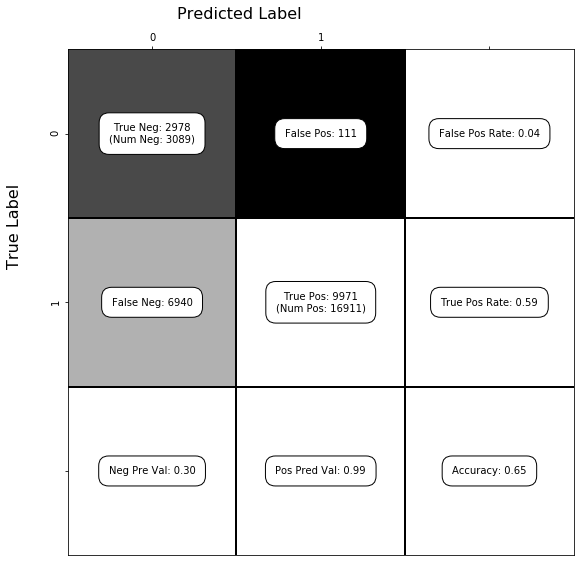

In [51]:
show_confusion_matrix(metrics_dict['confusion_matrix'])

#### 2.  BERT last 4 layer hidden states as embeddings

In [52]:
x_train = []
for sentence in tqdm(text_train):
    x_train.append(embed_model.sentence2vec(sentence, layers=embed_model.LAST_4_LAYERS))
    
x_test = []
for sentence in tqdm(text_test):
    x_test.append(embed_model.sentence2vec(sentence, layers=embed_model.LAST_4_LAYERS))

100%|████████████████████████████████████| 20000/20000 [29:11<00:00,  9.46it/s]


In [53]:
parameters = {'loss' :['log'],'penalty':['l1','l2','elasticnet'],'alpha':[float(i)/10000000 for i in range(1,5,1)],'n_jobs':[-1]}
LR = SGDClassifier(fit_intercept=True, random_state=42)
scoring = 'recall'

In [54]:
LR = SGDClassifier(fit_intercept=True)
clf = model_grid_search(parameters, x_train, y_train, model=LR, scoring=scoring)
print("Best params grid search", clf.best_params_)
y_pred = clf.predict(x_test)
metrics_dict = test_metrics(y_pred, y_test)
print("Precision", metrics_dict['precision'])
print("Recall", metrics_dict['recall'])
print("f1 score", metrics_dict['F1'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=

Best params grid search {'alpha': 2e-07, 'loss': 'log', 'n_jobs': -1, 'penalty': 'l2'}
Precision 97.86965441060438
Recall 73.34870794157649
f1 score 83.85330403920906


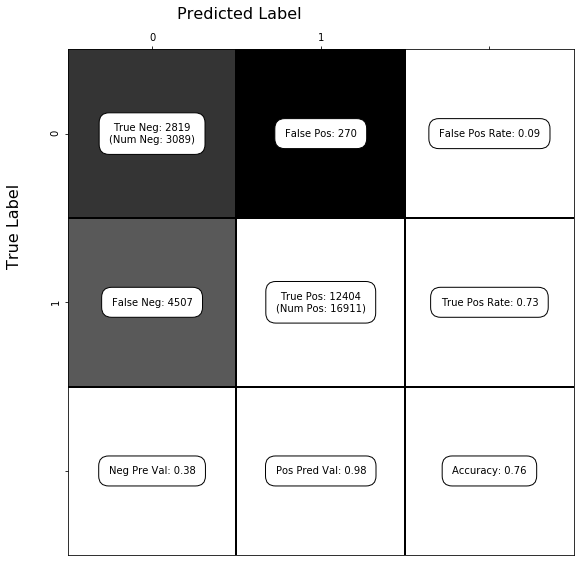

In [55]:
show_confusion_matrix(metrics_dict['confusion_matrix'])

## Things to try:

1. Try different non-linear classifiers (decision tree, random forest .etc) to achieve better results than the baseline.
2. Try different ways of building your word embeddings and use that on your desired classification model: (refer to the previous section [above](https://colab.research.google.com/drive/1g7OWTJKVWwij9Bit9nZDamaUI2--fjmO#scrollTo=ytonVXQWGcei))
    - Sum of all 12 layer hidden states (word embedding would be of size 768)
    - First layer hidden state (word embedding would be of size 768)
    - Second to last layer hidden state (word embedding would be of size 768)
    - Concat of last 4 layer hidden states (word embedding would be of size 768 * 4)
3. Use larger models such as `bert-large-uncased` instead of `bert-base-uncased`
3. You can also use `BERT as service`, to obtain <a href="https://github.com/hanxiao/bert-as-service#getting-elmo-like-contextual-word-embedding">sentence embeddings</a> (it supports many other features as well and their repo is pretty well documented) 

## References:
1. https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/
2. http://jalammar.github.io/illustrated-bert/
3. https://jalammar.github.io/illustrated-transformer/
4. https://towardsdatascience.com/nlp-extract-contextualized-embeddings-from-bert-keras-tf-67ef29f60a7b
5. [Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html): a blogpost by Professor Sasha Rush describing the transformer architecture by implementing it from the paper in PyTorch.